# Channel impulse response

In [9]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import scienceplots

# plt.style.use(['science', 'grid', 'no-latex'])
plt.style.use(['science', 'grid', 'ieee', 'no-latex'])

D = 1e-9 # Diffusion coefficient (m^2/s)
d = 5e-6 # Distance between source and receiver (m)
r = 1e-6 # Receiver radius (m)
N_tx = 1e6 # Number of transmitted molecules

# T_s = 1e-7 # Symbol duration (s)
t_peak = d**2 / (6 * D)
T_s = t_peak / 16 # Sample interval, it is also the shortest simulation time step length
print(f"t_peak = {t_peak}")
print(f"T_s = {T_s}")

N_s = 256 # Number of samples in one symbol

v_rx = 4/3 * np.pi * r**3 # Volume of the receiver (m^3)

position_tx = np.array([0, 0, 0]) # Position of the transmitter (m)
position_rx = np.array([d, 0, 0]) # Position of the receiver (m)

t_values = np.arange(T_s, T_s * N_s, T_s)

t_peak = 0.004166666666666667
T_s = 0.00026041666666666666


In [10]:
def p_rx(t):
    return (
        1/(4 * np.pi * D * t)**(3/2) * np.exp(-np.linalg.norm(position_tx - position_rx)**2/(4 * D * t))
    )

def c_rx(t):
    return (
        N_tx * p_rx(t)
    )

def counting_noise(c_rx_value):
    return (
        np.random.normal(0, np.sqrt(c_rx_value / v_rx))
    )

In [11]:
c_rx_values = np.array([c_rx(t) for t in t_values])
c_rx_values_noisy = c_rx_values + counting_noise(c_rx_values)

# fig, ax = plt.subplots(figsize=(6, 4))
# ax.plot(t_values, c_rx_values, label='$c_{rx}(t)$')
# ax.plot(t_values, c_rx_values_noisy, label='$c_{rx}(t)$ with noise')
# ax.set_xlabel('$t(s)$')
# ax.set_ylabel('$p_{rx}(t)$')
# ax.legend()
# plt.show()

In [12]:
import re

def extract_positions(file_path):
    """
    Reads an OpenFOAM positions file and extracts the particle positions.
    
    The file format is assumed to have a header, then a number indicating the total
    number of particles, followed by a '(' line, a series of lines with particle data,
    and finally a closing ')' line.
    
    Each particle data line has the form:
      (x y z) someNumber
    and we only extract the x, y, z coordinates.
    """
    positions = []
    with open(file_path, 'r') as f:
        in_data_block = False
        for line in f:
            line = line.strip()
            # Start reading the coordinate data when encountering the "(" line
            if not in_data_block:
                if line == '(':
                    in_data_block = True
                continue
            # Stop when we hit the closing ")"
            if line == ')':
                break
            # Extract the part within parentheses using regex
            match = re.search(r'\((.*?)\)', line)
            if match:
                # Split the string by whitespace and convert to float
                coords = [float(val) for val in match.group(1).split()]
                positions.append(coords)
    return np.array(positions)

In [13]:
import os
import numpy as np

def checkPath(path):
    # if not isinstance(path, str):
    #     raise ValueError("path must be a string")
    if not os.path.exists(path):
        raise FileNotFoundError(f"The specified path {path} does not exist")

def getOpenfoamTimeDirList(simulation_base_path):
    checkPath(simulation_base_path)
    
    def is_float(string):
        try:
            float(string)
            return True
        except ValueError:
            return False

    arr = os.listdir(simulation_base_path)
    time_stamps = [x for x in arr if is_float(x)]
    time_stamps.sort()

    return time_stamps


def getPosition(file_positions):
    checkPath(file_positions)
    
    with open(file_positions) as f:
        lines = f.readlines() # Read all lines
        lines = [x.strip() for x in lines] # Remove leading and trailing whitespaces

        n_row_start = lines.index('(') # Find the start of the positions
        n_row_end = lines.index(')') # Find the end of the positions

        lines_target = lines[n_row_start+1:n_row_end] # Extract the lines with positions

        positions = np.zeros((len(lines_target), 3)) # Initialize the positions array
        for idx_line, line in enumerate(lines_target): # Parse the lines with positions
            nums = line.replace('(', '').replace(')', '').split()
            positions[idx_line, 0] = float(nums[0])
            positions[idx_line, 1] = float(nums[1])
            positions[idx_line, 2] = float(nums[2])

    return positions
        

def isInsideSphere(positions, rx_center, rx_radius):    
    # Calculate the distance between each molecule and the receiver
    distances = np.linalg.norm(positions - rx_center, axis=1)

    # Count the number of molecules inside the receiver
    num_molecules = (distances <= rx_radius).sum()

    return num_molecules


# counting number of molecules inside the sphereical receiver
def getChannelImpulseResponse(simulation_base_path, rx_center, rx_radius):
    checkPath(simulation_base_path)
    
    time_stamps = getOpenfoamTimeDirList(simulation_base_path)

    if len(time_stamps) == 0:
        print("No simulated results (time stamp directories) are found")
        return None

    CIR = np.zeros((len(time_stamps), 2))
    CIR[:, 0] = np.array(time_stamps)

    for idx_time, time_stamp in enumerate(time_stamps):
        file_positions = f"{simulation_base_path}/{time_stamp}/lagrangian/kinematicCloud/positions"
        # print(f"Processing: {file_positions}")
        try:
                positions = getPosition(file_positions)

                # num_molecules = ((positions[:,2] >= zi_lower) & (positions[:,2] <= zi_upper)).sum()
                # CIR[idx_time, 1] = num_molecules
                
                num_molecules = isInsideSphere(positions, rx_center, rx_radius)
                CIR[idx_time, 1] = num_molecules

        except FileNotFoundError:
            pass
        
    # sort the CIR based on the time stamps
    CIR = CIR[CIR[:, 0].argsort()]

    return CIR


# Read openfoam results

In [14]:
import os
import numpy as np
import re

# check if current directory contains cir.npy, if yes, skip reading the OpenFOAM data
if os.path.exists('cir.npy'):
    cir_openfoam = np.load('cir.npy')
else:
    cir_openfoam = getChannelImpulseResponse('./', position_rx, r)
    cir_openfoam[:,1] = cir_openfoam[:,1] / v_rx
    np.save('cir.npy', cir_openfoam)

# # List all directories in the current directory
# directories = [d for d in os.listdir() if os.path.isdir(d)]

# # Filter out directories that do not contain numbers
# filtered_dirs = np.array([d for d in directories if re.search(r'\d', d)])
# filtered_dirs = np.sort(filtered_dirs)
# filtered_dirs = np.delete(filtered_dirs, 0)

# time_openfoam = filtered_dirs.astype(float)

# target_files = './' + filtered_dirs + '/lagrangian/kinematicCloud/positions'


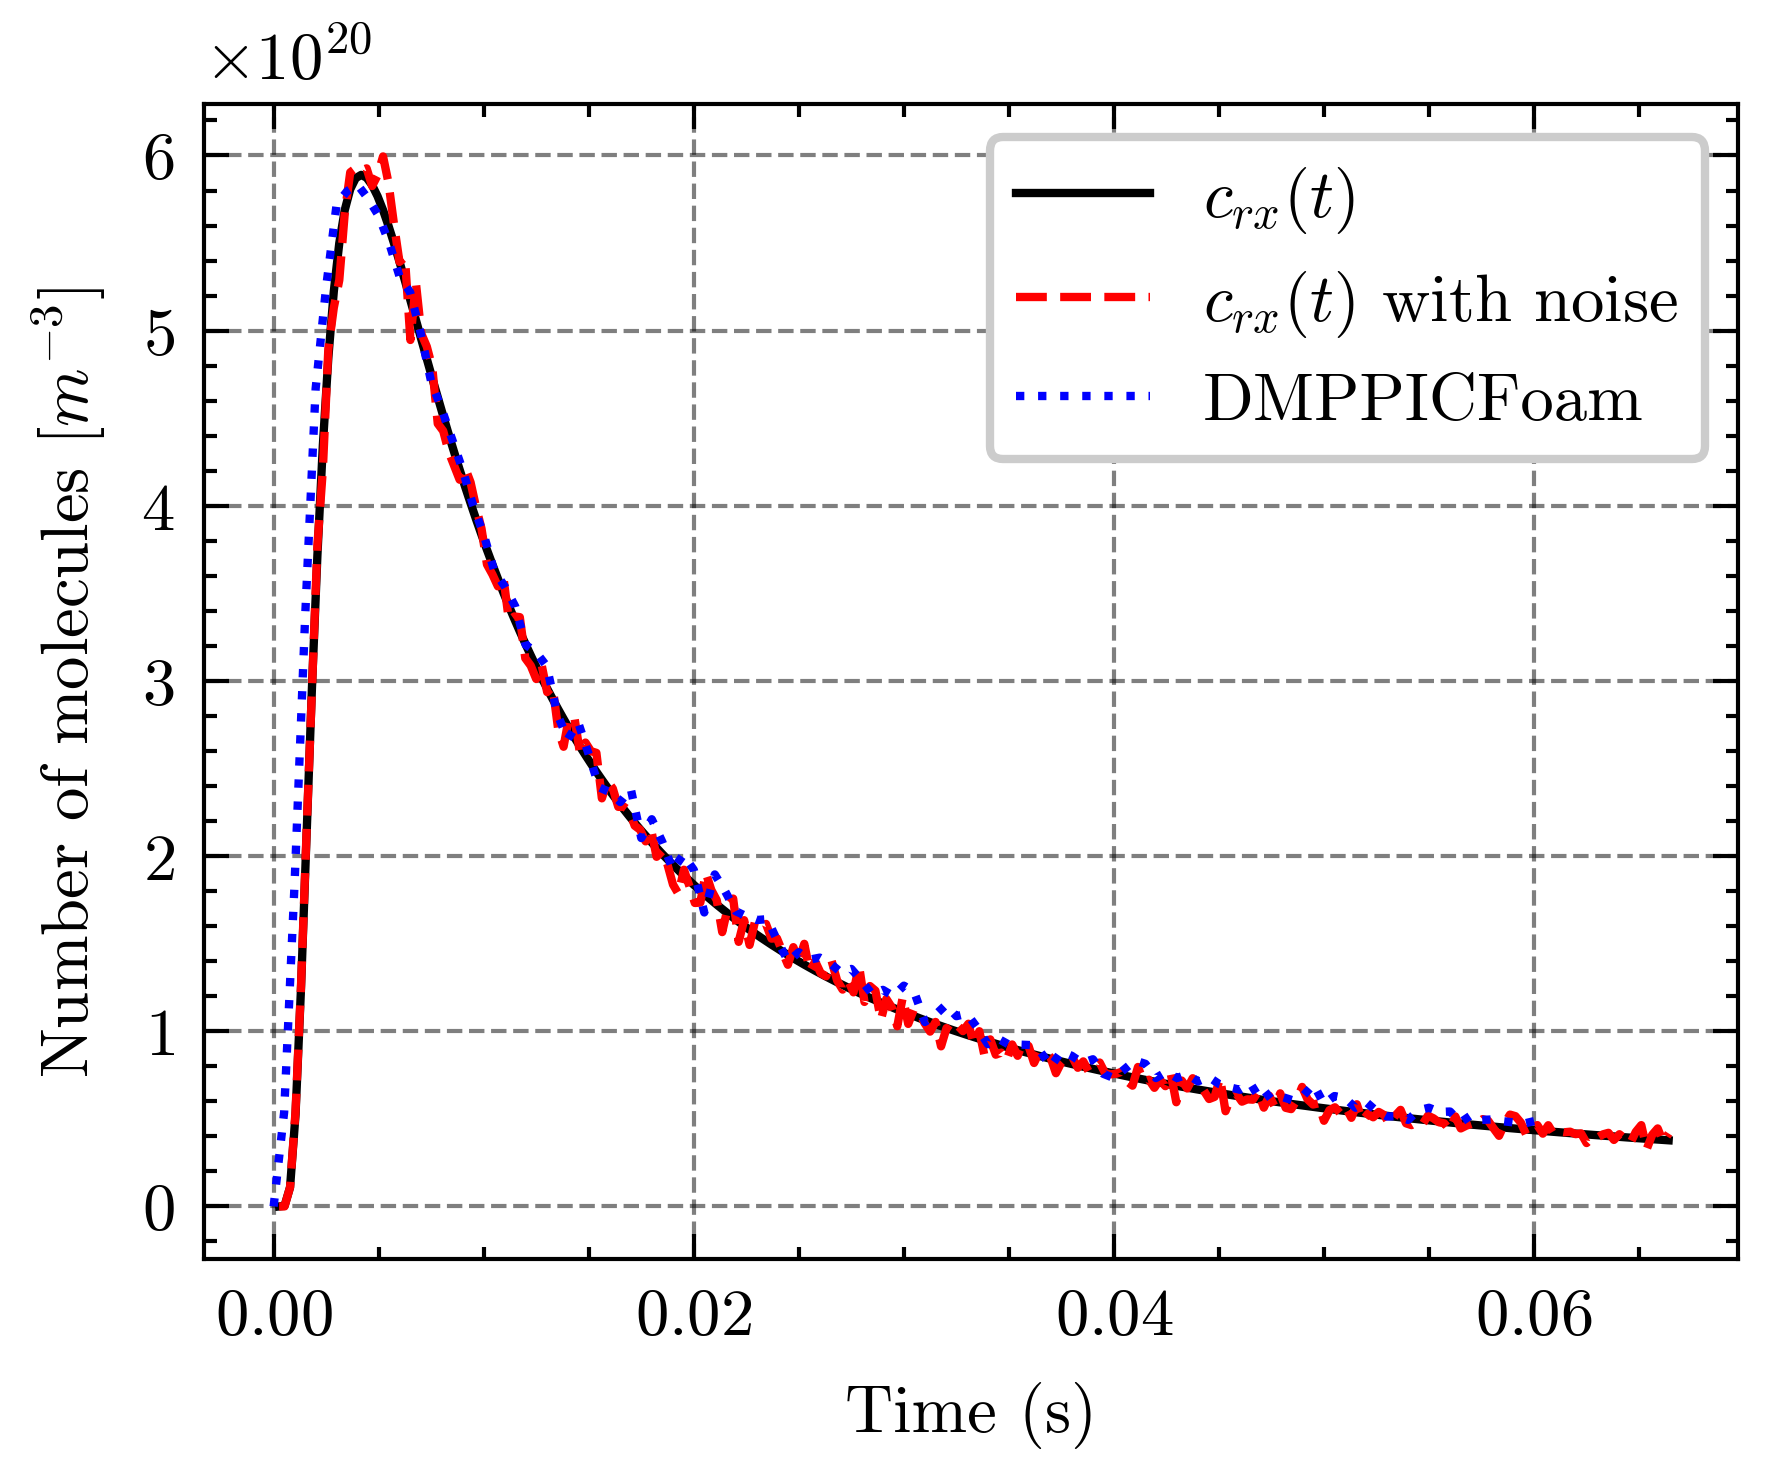

In [15]:
# plt.figure(figsize=(12, 8))
plt.plot(t_values, c_rx_values, label='$c_{rx}(t)$')
plt.plot(t_values, c_rx_values_noisy, label='$c_{rx}(t)$ with noise')
# plt.plot(cir[:, 0], cir[:, 1], linestyle='--', label='simulation')
plt.plot(cir_openfoam[:, 0], cir_openfoam[:, 1], label='DMPPICFoam')
plt.xlabel('Time (s)')
plt.ylabel('Number of molecules [$m^{-3}$]')
# plt.title('Molecule Count Inside Receiver Over Time')
plt.legend()

In [16]:
print(f'Time end = {t_values[-1]}')

Time end = 0.06640625
